In [ ]:
import torch
from torch import nn as nn
from torch.distributions import Normal, multivariate_normal
from torch.utils.data import Dataset, DataLoader
import numpy as np
import collections
from typing import Iterable
import scipy.sparse as sp_sparse
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from tqdm import trange
import sys
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import scanpy as sc

In [46]:
class Generate_X:
    def __init__(self, p, give_mean = 'zero', give_sigma = 'one'):
        """
        give_sigma: whether the Sigma is diagonal matrix and same across cell types.
                    'one': The variances of genes are all ones.
                    'linspace': The variances of genes are different but even spaced numbers
                    'uniform': The variances of gene are randomly generated from [0,1]
        """
        self.p = p
        if give_mean is 'zero':
            self.mean = np.array([0]*self.p, dtype =float)
        elif give_mean is 'linspace':
            self.mean = np.linspace(0,2,num = self.p, dtype=float)
        elif give_mean is 'uniform':
            self.mean =  np.random.rand(self.p, dtype = float)
        else:
            print('Wrong argument!')
            pass
        if give_sigma is 'one':
            self.sigma = np.array([1]*self.p)
        elif give_sigma is 'linspace':
            self.sigma = np.linspace(0,2,num = self.p)
        elif give_mean is 'uniform':
            self.sigma =  np.random.rand(self.p)
        else:
            print('Wrong argument!')
            pass
        

    def sym_Sigma(self):
        p = self.p
        L = np.tril(np.random.random((p,p))*2,0)
        sparse = np.random.binomial(1,0.2,(p,p))
        diag_indices = np.diag_indices(p)
        sparse[diag_indices] = 1
        L = L * sparse
        S = np.matmul(L,L.transpose())
        return S

    def generate(self, m_vec, n_vec, same_mean = True, same_sigma = True):
        """
        m_vec: the vector of #m off-diagonal nonzero cov entries
        n_vec: the vector of cell size
        """
        assert len(m_vec) == len(n_vec)
        ct_label = []
        rst = []
        covmat = []
        meanmat = []
        for ct in range(len(m_vec)):  # ct: cell type
            if same_sigma:
                Sigma = np.diag(self.sigma)
            else:
                Sigma = self.sym_Sigma()
            Sigma = Sigma.astype(float)
            if same_mean:
                mean = self.mean
            else:
                mean = np.random.rand(self.p)*2
            MVN = np.random.multivariate_normal(mean, Sigma, n_vec[ct])
            #print(MVN)
            rst.append(MVN)
            ct_label.append(np.array([ct]*n_vec[ct]))
            covmat.append(Sigma)
            meanmat.append(mean)
        mat = np.array(rst)
        ct_label = np.array(ct_label)
        self.X = np.reshape(mat, (-1,self.p))
        self.ct_label = np.reshape(ct_label, (-1,))
        self.covmat = covmat
        self.meanmat = meanmat
        # print(self.X, self.ct_label)

In [3]:
def sim_sample_indices(sample_size):
    sample_indices = [[i]*sample_size[i] for i in range(len(sample_size))]
    return np.asarray(sample_indices).flatten()

In [4]:
class CytofDataset_Sim(Dataset):
    """ Create CyTOF dataset for Pytorch in Simulation"""

    def __init__(self,X, sample_indices, label_indices):
        self.dense = type(X) is np.ndarray
        self._X = np.ascontiguousarray(X, dtype=np.float32) if self.dense else X
        self.nb_genes = self.X.shape[1]
        self.samples, self.n_samples, self.sample_dict = arrange_categories(sample_indices)
        self.labels, self.n_labels, self.label_dict = arrange_categories(label_indices)

    @property
    def X(self):
        return self._X

    def __len__(self):
        return self._X.shape[0]
    
    def __getitem__(self, idx):
        return idx
    
    def collate_fn(self, batch):
        indexes = np.array(batch)
        X = self.X[indexes]
        return self.collate_fn_end(X, indexes)
    
    def collate_fn_end(self, X, indexes):

        if self.dense:
            X = torch.from_numpy(X)
        else:
            X = torch.FloatTensor(X.toarray())
        return X,  torch.LongTensor(self.samples[indexes]), \
                   torch.LongTensor(self.labels[indexes])


    def get_sample(self, sample_sublist):
        """
        sample_sublist: list
        """
        loc = np.array([np.where(self.samples == self.sample_dict[sample]) for sample in sample_sublist]).flatten()
        X_sub = self._X[loc]
        samples_sub = self.samples[loc]
        labels_sub = self.labels[loc]
        return X_sub, samples_sub, labels_sub
    
    def get_celltype(self, celltype_sublist):
        """
        celltype_sublist: list
        """
        loc = np.array([np.where(self.labels == self.label_dict[batch]) for label in celltype_sublist]).flatten()
        X_sub = self._X[loc]
        samples_sub = self.samples[loc]
        labels_sub = self.labels[loc]
        return X_sub, samples_sub, labels_sub

In [5]:
def arrange_categories(original_categories, mapping_from=None, mapping_to=None):
    unique_categories = np.unique(original_categories)
    n_categories = len(unique_categories)
    batch_dict = dict()
    if mapping_to is None:
        mapping_to = range(n_categories)
    if mapping_from is None:
        mapping_from = unique_categories
    assert n_categories <= len(mapping_from)  # one cell_type can have no instance in dataset
    assert len(mapping_to) == len(mapping_from)

    new_categories = np.copy(original_categories)
    for idx_from, idx_to in zip(mapping_from, mapping_to):
        # print(idx_from, idx_to)
        new_categories[original_categories == idx_from] = idx_to
        batch_dict[idx_from] = idx_to
    return new_categories.astype(int), n_categories, batch_dict

In [6]:
class FCLayers(nn.Module):
    r"""A helper class to build fully-connected layers for a neural network.

    :param n_in: The dimensionality of the input
    :param n_out: The dimensionality of the output
    :param n_layers: The number of fully-connected hidden layers
    :param n_hidden: The number of nodes per hidden layer
    :param dropout_rate: Dropout rate to apply to each of the hidden layers
    """

    def __init__(self, n_in: int, n_out: int, 
                 n_layers: int = 1, n_hidden: int = 128, dropout_rate: float = 0.1, use_batch_norm=True):
        super(FCLayers, self).__init__()
        layers_dim = [n_in] + (n_layers - 1) * [n_hidden] + [n_out]

        self.fc_layers = nn.Sequential(collections.OrderedDict(
            [('Layer {}'.format(i), nn.Sequential(
                nn.Linear(n_in , n_out),
                nn.BatchNorm1d(n_out, momentum=.01, eps=0.001) if use_batch_norm else None,
                nn.ReLU(),
                nn.Dropout(p=dropout_rate) if dropout_rate > 0 else None))
             for i, (n_in, n_out) in enumerate(zip(layers_dim[:-1], layers_dim[1:]))] ))

    def forward(self, x: torch.Tensor):
        r"""Forward computation on ``x``.

        :param x: tensor of values with shape ``(n_in,)``
        :return: tensor of shape ``(n_out,)``
        :rtype: :py:class:`torch.Tensor`
        """
        
        for layers in self.fc_layers:
            for layer in layers:
                if layer is not None:
                    if isinstance(layer, nn.BatchNorm1d):
                        if x.dim() == 3:
                            x = torch.cat([(layer(slice_x)).unsqueeze(0) for slice_x in x], dim=0)
                        else:
                            x = layer(x)
                    else:
                        x = layer(x)
        return x

In [7]:
class Encoder(nn.Module):
    r"""Encodes data of ``n_input`` dimensions into a latent space of ``n_output``
    dimensions using a fully-connected neural network of ``n_hidden`` layers.

    :param n_input: The dimensionality of the input (data space)
    :param n_output: The dimensionality of the output (latent space)
    :param n_layers: The number of fully-connected hidden layers
    :param n_hidden: The number of nodes per hidden layer
    :dropout_rate: Dropout rate to apply to each of the hidden layers
    """

    def __init__(self, n_input: int, n_output: int,
                 n_layers: int = 1,
                 n_hidden: int = 128, dropout_rate: float = 0.1):
        super(Encoder, self).__init__()

        self.encoder = FCLayers(n_in=n_input, n_out=n_hidden, n_layers=n_layers,
                                n_hidden=n_hidden, dropout_rate=dropout_rate)
        self.mean_encoder = nn.Linear(n_hidden, n_output)
        self.var_encoder = nn.Linear(n_hidden, n_output)

    def reparameterize(self, mu, var):
        return Normal(mu, var.sqrt()).rsample()

    def forward(self, x: torch.Tensor):
        r"""The forward computation for a single sample.

         #. Encodes the data into latent space using the encoder network
         #. Generates a mean \\( q_m \\) and variance \\( q_v \\) (clamped to \\( [-5, 5] \\))
         #. Samples a new value from an i.i.d. multivariate normal \\( \\sim N(q_m, \\mathbf{I}q_v) \\)

        :param x: tensor with shape (n_input,)
        :return: tensors of shape ``(n_latent,)`` for mean and var, and sample
        :rtype: 3-tuple of :py:class:`torch.Tensor`
        """

        # Parameters for latent distribution
        q = self.encoder(x)
        q_m = self.mean_encoder(q)
        q_v = torch.exp(self.var_encoder(q))  # (computational stability safeguard)torch.clamp(, -5, 5)
        latent = self.reparameterize(q_m, q_v)
        return q_m, q_v, latent

In [8]:
class DecoderVCSC(nn.Module):
    r"""Decodes data from latent space of ``n_input`` dimensions ``n_output``
    dimensions using a fully-connected neural network of ``n_hidden`` layers.

    :param n_input: The dimensionality of the input (latent space)
    :param n_output: The dimensionality of the output (data space). It is also the number of genes
    :param n_cat_list: A list containing the number of categories
    :param n_layers: The number of fully-connected hidden layers
    :param n_hidden: The number of nodes per hidden layer
    :param dropout_rate: Dropout rate to apply to each of the hidden layers
    """

    def __init__(self, n_input: int, n_output: int,
                 n_layers: int = 1,
                 n_hidden: int = 128):
        super(DecoderVCSC, self).__init__()

        # shape: shape parameter in gamma distribution infered from estimated covariance matrix
        self.px_mu_decoder = FCLayers(n_in = n_input, n_out = n_output, 
                                    n_layers=n_layers, n_hidden=n_hidden, dropout_rate=0)

        # scale: scale parameter in gamma distribution infered from estimated covariance matrix
        self.px_sd_decoder = FCLayers(n_in = n_input, n_out = n_output, 
                                    n_layers=n_layers, n_hidden=n_hidden, dropout_rate=0)
        self.px_sd_decoder_positive = nn.Softmax(dim=1)

        # shape: shape parameter in gamma distribution infered from estimated covariance matrix
        self.px_L_decoder = FCLayers(n_in = n_input, n_out = int(n_output*(n_output-1)/2), 
                                    n_layers=n_layers, n_hidden=n_hidden, dropout_rate=0)

        # dropout
        #self.px_dropout_decoder = nn.Linear(n_hidden, n_output)




    def forward(self, z: torch.Tensor):
        r"""The forward computation for a single sample.

         #. Decodes the data from the latent space using the decoder network
         #. Returns parameters for the ZINB distribution of expression

        :param z: tensor with shape ``(n_input,)``
        :param theta: empirical dispersion parameter in Gamma distribution with shape ``(#gene,)``
        :return: parameters for the ZINB distribution of expression
        :rtype: 4-tuple of :py:class:`torch.Tensor`
        """

        # scale parameter in gamma distribution: \theta
        

        # The decoder returns values for the parameters of the ZINB distribution
        px_mu = self.px_mu_decoder(z)
        px_sd = self.px_sd_decoder(z)
        px_sd = self.px_sd_decoder_positive(px_sd)
        px_L = self.px_L_decoder(z)
        #print(px_L.size())
        #px_L = self.ReshapeL(px_L)
        #px_L = self.ReshapeL(px_L)
        #px_dropout = self.px_dropout_decoder(px_sigma)
        
        
        return px_mu, px_sd, px_L

In [9]:
def ReshapeL(L: torch.Tensor):
    n = int(np.sqrt(len(L)*2))+1
    mask = torch.arange(n)[:,None]>torch.arange(n)
    px_L = torch.zeros((n,n),dtype=torch.float)
    #print(mask.size(),px_L.size())
    #print(px_L[mask].size(),L.size())
    px_L[mask] = L
    return px_L

In [10]:
def ReshapeL2(L: torch.Tensor):
    """
    n: minibatch or sample size
    L: vectorization of lower triangular
    """
    if L.ndimension() <= 1:
        print("Sample size less than 2!")
        pass
    
    p = int(np.sqrt(L.size()[1]*2))+1
    n = L.size()[0]
    segment = torch.cat( (torch.zeros(1), torch.arange(9,0,-1, dtype = torch.float).cumsum(0)) )
    segment = segment.to(torch.int8)
    # print(segment)
    L_new = torch.zeros(n, p*p)
    for i, (start, end) in enumerate(zip(segment[:-1],segment[1:])):
        #print(i, L[:,start:end])
        zero_mat = torch.zeros(n,i)
        L_sub = L[:,start:end]
        one_mat = torch.ones(n,1)
        #print(zero_mat.size(), L_sub.size())
        #print(torch.cat( [zero_mat, L_sub], dim = 1 ).size() )
        L_new_sub = torch.cat( [zero_mat, L_sub], dim = 1 )
        #print(L_new_sub.size())
        #print(L_new[:, (i*p):(i*p+p)].size(), p)
        
        L_new[:, (i*p):(i*p+p)] = torch.cat( [zero_mat, one_mat,  L_sub], dim = 1 )
    L_new[:,-1]=torch.ones(n)
    return L_new
    

In [11]:
def ReshapeX(p, x: torch.Tensor):
    """
    Expand X to repeat p times
    """
    assert p ==  x.size()[1]
    x = x.repeat(1, p)
    return x

In [12]:
def ReshapeX2(p,x_expand: torch.Tensor):
    """
    x_expand.size(): [minibatch * (p*p)]
    Reshape back expanded X to the original shape by cumulative sum.
    """
    assert p*p == x_expand.size()[1]
    x_expand = x_expand.to(torch.float)
    n = x_expand.size()[0]
    segment = torch.cat( (torch.zeros(1), torch.tensor([p]*p, dtype=torch.float).cumsum(0)) )
    segment = segment.to(torch.int8)
    x_new = torch.zeros(n,p)
    for i, (start, end) in enumerate(zip(segment[:-1], segment[1:])):
        x_sub = x_expand[:, start:end]
        #print(x_sub.size(), x_new.size())
        x_new[i,:] = x_sub.sum(dim=0)
    return x_new

In [13]:
def log_gaussian_positive(x, px_mu, px_sd, px_L, eps=1e-8):
    """
    Note: All inputs should be torch Tensors
    log likelihood (scalar) of a minibatch according to a gaussian model.

    Variables:
    mu: mean  (shape: minibatch x genes)
    sd: sd (shape: minibatch x genes)
    L: vector of lower-triangular in Cholesky Decomposition, need to be reshalpe
    eps: numerical stability constant
    """
    
    px_L = ReshapeL2(px_L) # shape of [minibatch * (p*p)]
    p = px_mu.size()[1]
    reconstruct_x = ReshapeX(p, x - px_mu) * px_L  # shape of [minibatch * (p*p)]
    reconstruct_x = ReshapeX2(p, reconstruct_x) # shape of [minibatch * p]
    reconstruct_x = reconstruct_x*px_sd # shape of [minibatch * p]

    res = - 0.5 * ( - 2*torch.log(px_sd+eps).sum(dim=-1) + (reconstruct_x**2).sum(dim=-1) )
    return res

In [75]:
class VAE(nn.Module):
    r"""Variational auto-encoder model.

    :param n_input: Number of input genes
    :param n_batch: Number of batches
    :param n_labels: Number of labels
    :param n_hidden: Number of nodes per hidden layer
    :param n_latent: Dimensionality of the latent space
    :param n_layers: Number of hidden layers used for encoder and decoder NNs
    :param dropout_rate: Dropout rate for neural networks

    :param log_variational: Log variational distribution
    :param reconstruction_loss:  One of

    """

    def __init__(self, n_input: int, n_labels: int = 18,
                 n_hidden: int = 128, n_latent: int = 10, n_layers: int = 1,
                 dropout_rate: float = 0.1, 
                 log_variational: bool = True):
        super(VAE, self).__init__()
        self.n_latent = n_latent
        self.log_variational = log_variational
        #self.reconstruction_loss = reconstruction_loss
        # Automatically deactivate if useless
        self.n_labels = n_labels
        self.n_latent_layers = 1  # not sure what this is for, no usages?

        self.z_encoder = Encoder(n_input, n_latent, n_layers=n_layers, n_hidden=n_hidden,
                                 dropout_rate=dropout_rate)
        # decoder goes from n_latent-dimensional space to n_input-d data
        self.decoder = DecoderVCSC(n_latent, n_input, n_layers=n_layers, n_hidden=n_hidden)

    def get_latents(self, x):
        r""" returns the result of ``sample_from_posterior_z`` inside a list

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :return: one element list of tensor
        :rtype: list of :py:class:`torch.Tensor`
        """
        return [self.sample_from_posterior_z(x)]

    def sample_from_posterior_z(self, x, give_mean=False):
        r""" samples the tensor of latent values from the posterior
        #doesn't really sample, returns the means of the posterior distribution

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :param give_mean: is True when we want the mean of the posterior  distribution rather than sampling
        :return: tensor of shape ``(batch_size, n_latent)``
        :rtype: :py:class:`torch.Tensor`
        """
        if self.log_variational:
            pass
        else:
            x= exp(x)-1
        qz_m, qz_v, z = self.z_encoder(x)  
        if give_mean:
            z = qz_m
        return z

    def get_sample_mu(self, x, batch_index=None, y=None, n_samples=1):
        r"""Returns the tensor of predicted frequencies of expression

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :param batch_index: array that indicates which batch the cells belong to with shape ``batch_size``
        :param n_samples: number of samples
        :return: tensor of predicted frequencies of expression with shape ``(batch_size, n_input)``
        :rtype: :py:class:`torch.Tensor`
        """
        return self.inference(x)[0]

    def get_sample_sd(self, x, batch_index=None, y=None, n_samples=1):
        r"""Returns the tensor of means of the negative binomial distribution

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :param y: tensor of cell-types labels with shape ``(batch_size, n_labels)``
        :param batch_index: array that indicates which batch the cells belong to with shape ``batch_size``
        :param n_samples: number of samples
        :return: tensor of means of the negative binomial distribution with shape ``(batch_size, n_input)``
        :rtype: :py:class:`torch.Tensor`
        """
        return self.inference(x)[1]

    def get_sample_L(self, x, batch_index=None, y=None, n_samples=1):
        r"""Returns the tensor of means of the negative binomial distribution

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :param y: tensor of cell-types labels with shape ``(batch_size, n_labels)``
        :param batch_index: array that indicates which batch the cells belong to with shape ``batch_size``
        :param n_samples: number of samples
        :return: tensor of means of the negative binomial distribution with shape ``(batch_size, n_input)``
        :rtype: :py:class:`torch.Tensor`
        """
        return self.inference(x)[2]

    def _reconstruction_loss(self, x, px_mu, px_sd, px_L):
        # Reconstruction Loss
        reconst_loss = -log_gaussian_positive(x, px_mu, px_sd, px_L)
        return reconst_loss

    def inference(self, x):
        x_ = x
        if self.log_variational:
            pass
        else:
            x_ = torch.exp(x_) - 1

        # Sampling
        qz_m, qz_v, z = self.z_encoder(x_)

        px_mu, px_sd, px_L = self.decoder(z)

        return px_mu, px_sd, px_L, qz_m, qz_v, z

    def forward(self, x):
        r""" Returns the reconstruction loss and the Kullback divergences

        :param x: tensor of values with shape (batch_size, n_input)
        :param local_l_mean: tensor of means of the prior distribution of latent variable l
         with shape (batch_size, 1)
        :param local_l_var: tensor of variancess of the prior distribution of latent variable l
         with shape (batch_size, 1)
        :param batch_index: array that indicates which batch the cells belong to with shape ``batch_size``
        :param y: tensor of cell-types labels with shape (batch_size, n_labels)
        :return: the reconstruction loss and the Kullback divergences
        :rtype: 2-tuple of :py:class:`torch.FloatTensor`
        """
        # Parameters for z latent distribution

        px_mu, px_sd, px_L, qz_m, qz_v, z = self.inference(x)
        reconst_loss = self._reconstruction_loss(x, px_mu, px_sd, px_L)

        # KL Divergence between two multivariate normal distributions
        mean = torch.zeros_like(qz_m)
        scale = torch.ones_like(qz_v)

        kl_divergence = torch.distributions.kl.kl_divergence(Normal(qz_m, torch.sqrt(qz_v)), Normal(mean, scale)).sum(dim=-1)


        return reconst_loss,  kl_divergence

In [88]:
class Trainer:
    """The abstract Trainer class for training a PyTorch model and monitoring its statistics. It should be
    inherited at least with a .loss() function to be optimized in the training loop.

    Args:
        :model: A model instance from class ``VAE``
        :gene_dataset: A gene_dataset instance like ``CortexDataset()``
        :use_cuda: Default: ``True``.
        :metrics_to_monitor: A list of the metrics to monitor. If not specified, will use the
            ``default_metrics_to_monitor`` as specified in each . Default: ``None``.
        :benchmark: if True, prevents statistics computation in the training. Default: ``False``.
        :verbose: If statistics should be displayed along training. Default: ``None``.
        :frequency: The frequency at which to keep track of statistics. Default: ``None``.
        :early_stopping_metric: The statistics on which to perform early stopping. Default: ``None``.
        :save_best_state_metric:  The statistics on which we keep the network weights achieving the best store, and
            restore them at the end of training. Default: ``None``.
        :on: The data_loader name reference for the ``early_stopping_metric`` and ``save_best_state_metric``, that
            should be specified if any of them is. Default: ``None``.
    """
    default_metrics_to_monitor = []
    

    def __init__(self, model, gene_dataset, benchmark=False,
                 verbose=False, kl=None):

        self.model = model
        self.gene_dataset = gene_dataset
        self.kl = kl
        self.verbose = verbose

        self.benchmark = benchmark
        self.epoch = -1  # epoch = self.epoch + 1 in compute metrics
        self.training_time = 0
        
        self.history = []

        # self.gamma_index = gamma_index
        # self.cor_gt = cor_gt
        # self.cell_label = cell_label

    def data_loaders_loop(self):
        data_loader =  torch.utils.data.DataLoader(self.gene_dataset, batch_size = 100, shuffle =True)
        return data_loader

    def train(self, n_epochs=20, lr=1e-3, eps=0.01, params=None):
        begin = time.time()
        self.model.train()

        if params is None:
            params = filter(lambda p: p.requires_grad, self.model.parameters())

        # if hasattr(self, 'optimizer'):
        #     optimizer = self.optimizer
        # else:
        optimizer = self.optimizer = torch.optim.Adam(params, lr=lr, eps=eps)  
        self.n_epochs = n_epochs

        with trange(n_epochs, desc="training", file=sys.stdout, disable=self.verbose) as pbar:
            # We have to use tqdm this way so it works in Jupyter notebook.
            # See https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook
            for self.epoch in pbar:
                self.on_epoch_begin()
                pbar.update(1)
                for tensors_list in self.data_loaders_loop():
                    tensors_list = self.gene_dataset.collate_fn(tensors_list)
                    X, sample_list, label_list = tensors_list
                    loss = self.loss(X)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    self.record_matrics(loss)
                    
        self.training_time += time.time() - begin
        print("\nTraining time:  %i s. / %i epochs" % (int(self.training_time), self.n_epochs))

    def loss(self, X):
        reconst_loss, kl_divergence = self.model(X)
        loss = torch.mean(reconst_loss + self.kl_weight * kl_divergence)
        return loss
    
    def record_matrics(self,loss):
        self.history += [loss]
        
    def plot_history(self):
        plt.plot(range(len(self.history)), self.history)


    def on_epoch_begin(self):
        self.kl_weight = self.kl if self.kl is not None else min(1, self.epoch / 400)  # self.n_epochs)
    
    @torch.no_grad()
    def get_latent(self):
        x = self.gene_dataset.X
        x = torch.from_numpy(x).float()
        z = self.model.get_latents(x)
        return z


In [47]:
sim1 = Generate_X(10)
sim1.generate([3,5],[1500,1500], same_mean = False, same_sigma = False)
sample_size = np.repeat(3000,1)
sample_indices = sim_sample_indices(sample_size)
#print(sample_indices)

In [50]:
simX_data = CytofDataset_Sim(sim1.X, sample_indices, sim1.ct_label)
simX, _, labels = simX_data.get_sample([0]) ## Used for simulation without multiple batches integration
gene_dataset = simX_data

In [93]:
p = 10 # dimension of X
d = 2 # dimension of z
n_input = p
n_latent = d
n_layers = 3
n_hidden = 20 # dimension of hidden layer
dropout_rate = 0.1
n_epochs = 1000
lr=1e-3

In [60]:
np.savetxt('./write/simulation', sim1.X, delimiter = ',')

In [61]:
adata = sc.read_csv('./write/simulation')

In [65]:
adata.obs['cell type'] = sim1.ct_label
adata.obs['batch'] = sample_indices

In [68]:
sc.pp.neighbors(adata, n_neighbors = 15, metric = 'euclidean', random_state = None)
sc.tl.umap(adata, min_dist = 0.1)

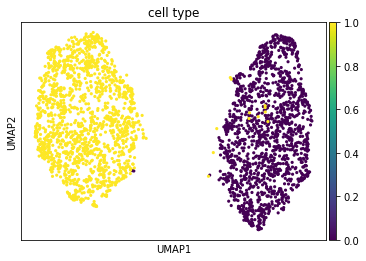

In [70]:
sc.pl.umap(adata, color = 'cell type')

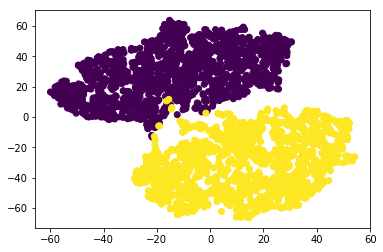

In [71]:
X_embedded = TSNE(n_components=2).fit_transform(gene_dataset.X)
raw_plt = plt.scatter(X_embedded[:,0], X_embedded[:,1], c = gene_dataset.labels)

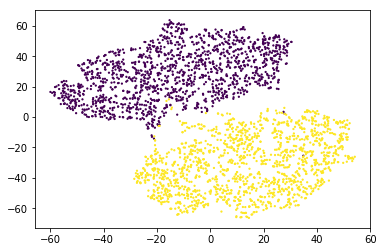

In [73]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = gene_dataset.labels, s = [1.5]*len(X_embedded))
plt.savefig('./figures/raw.7302019.3000.png')

In [94]:
vae = VAE(gene_dataset.nb_genes, gene_dataset.n_labels)
trainer = Trainer(vae, gene_dataset)
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 1000/1000 [03:23<00:00,  4.92it/s]

Training time:  203 s. / 1000 epochs


In [95]:
z = trainer.get_latent()
z = z[0].numpy()

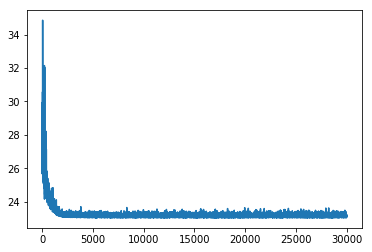

In [96]:
len(trainer.history)
trainer.plot_history()

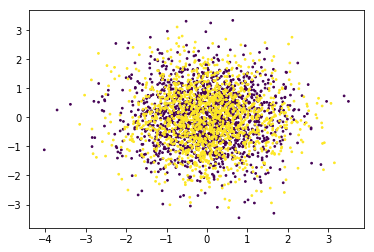

In [97]:
plt.scatter(z[:,0], z[:,1], c = gene_dataset.labels, s = [3]*len(z))
plt.savefig('./figures/vae.7242019.3000.png')

In [25]:
sim1.covmat


[array([[3.23097108e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         4.13897426e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 3.28185831e-01],
        [0.00000000e+00, 1.23198685e-03, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.51182501e-01, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.31837324e-01,
         0.00000000e+00, 0.00000000e+00, 4.58604631e-01, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [4.13897426e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         3.50564747e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0

In [26]:
sim1.meanmat

[array([0.47351306, 0.97317736, 0.63798234, 0.33913694, 0.30553139,
        0.74113826, 0.65585018, 0.493678  , 0.48899479, 0.57086916]),
 array([0.78855394, 0.97232755, 0.38023787, 0.83915071, 0.91736467,
        0.44281143, 0.23330857, 0.74829334, 0.44301535, 0.80112935])]